# Brief decription of the Project

(Blurb about ride sharing and bikes)

Making use of the data made available by Lyft, I sought to learn more about Bike Sharing usage in San Francisco.

Specifically, the goal of this project is 3-fold:

- Quantify the business trends over time.

- Investigate the user profile along multiple dimensions.

- Forecast daily bike usage.


## 1 - Quantify the business trends over time.

Total Number of trips per month for the last 3 years

Trip duration distribution

Trip start time distribution: weekdays vs weekends

Trip Distance distribution: weekdays vs weekends

All to all flow chart of trips between stations: year by year

Analyze dimensionality of the data (build n_station X n_days matrix and run PCA on daily trips/start station) 


## 2 - Investigate the user profile along multiple dimensions.

Median user age over time

Age distribution by gender. 

Gender gap in user profile over time.

Pairwise analysis of start time, trip duration and age - do users cluster over certain features?

Is distance inversely correlated with age?

## 3 - Forecast daily bike usage.


How well can you predict #trips a day based on historical data?

Does more past data help or hurt predictions?

Is weather data predictive or postdictive of #trips? 

Can NN beat simple forecasting analyses (different flavors from basic next day prediction to Linear Regression)?
Play with window size 


## Data used and licensing

The Data: https://www.lyft.com/bikes/bay-wheels/system-data

Each trip is anonymized and includes:

Trip Duration (seconds)

Start Time and Date

End Time and Date

Start Station ID

Start Station Name

Start Station Latitude

Start Station Longitude

End Station ID

End Station Name

End Station Latitude

End Station Longitude

Bike ID

User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual)

Member Year of Birth

Member Gender


In [79]:
# imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import math
import scipy.stats as spstats
#import plotly.graph_objects as go

In [2]:
# define data source
extension = 'csv'
all_filenames = [i for i in glob.glob('LyftData/*.{}'.format(extension))]
all_filenames_sorted = sorted(all_filenames)
print(all_filenames_sorted)

['LyftData/2017-fordgobike-tripdata.csv', 'LyftData/201801-fordgobike-tripdata.csv', 'LyftData/201802-fordgobike-tripdata.csv', 'LyftData/201803-fordgobike-tripdata.csv', 'LyftData/201804-fordgobike-tripdata.csv', 'LyftData/201805-fordgobike-tripdata.csv', 'LyftData/201806-fordgobike-tripdata.csv', 'LyftData/201807-fordgobike-tripdata.csv', 'LyftData/201808-fordgobike-tripdata.csv', 'LyftData/201809-fordgobike-tripdata.csv', 'LyftData/201810-fordgobike-tripdata.csv', 'LyftData/201811-fordgobike-tripdata.csv', 'LyftData/201812-fordgobike-tripdata.csv', 'LyftData/201901-fordgobike-tripdata.csv', 'LyftData/201902-fordgobike-tripdata.csv', 'LyftData/201903-fordgobike-tripdata.csv', 'LyftData/201904-fordgobike-tripdata.csv', 'LyftData/201905-baywheels-tripdata.csv', 'LyftData/201906-baywheels-tripdata.csv', 'LyftData/201907-baywheels-tripdata.csv', 'LyftData/201908-baywheels-tripdata.csv']


In [3]:
year ='2019'
[print(f) for f in all_filenames_sorted if year in f ]

LyftData/201901-fordgobike-tripdata.csv
LyftData/201902-fordgobike-tripdata.csv
LyftData/201903-fordgobike-tripdata.csv
LyftData/201904-fordgobike-tripdata.csv
LyftData/201905-baywheels-tripdata.csv
LyftData/201906-baywheels-tripdata.csv
LyftData/201907-baywheels-tripdata.csv
LyftData/201908-baywheels-tripdata.csv


[None, None, None, None, None, None, None, None]

In [4]:
# define data frames (1 per year)

def create_dataframe_year(year,file_list):
    dateparse = lambda x: pd.datetime.strptime(x.split('.')[0], '%Y-%m-%d %H:%M:%S')
    data_frame = pd.concat([pd.read_csv(f, parse_dates=['start_time'], date_parser=dateparse) for f in file_list if year in f ])
    return data_frame

In [5]:
#def create_dataframe_year(year,file_list):
#    data_frame = pd.concat([pd.read_csv(f) for f in file_list if year in f ])
#    return data_frame

In [6]:

data_frame_2017 = create_dataframe_year(year = '2017',file_list = all_filenames_sorted)
data_frame_2018 = create_dataframe_year(year = '2018',file_list = all_filenames_sorted)


In [7]:
data_frame_2019 = create_dataframe_year(year = '2019',file_list = all_filenames_sorted)

/Users/diogopeixoto/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/diogopeixoto/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/diogopeixoto/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """


In [8]:
data_frame_2017_sorted = data_frame_2017.sort_values(by=['start_time'])
data_frame_2018_sorted = data_frame_2018.sort_values(by=['start_time'])
data_frame_2019_sorted = data_frame_2019.sort_values(by=['start_time'])

In [9]:
A = data_frame_2018_sorted["start_time"].apply(lambda x: x.weekday())
np.unique(A)
#data_frame_2017_sorted_month = data_frame_2017_sorted[A==1]
#data_frame_2017_sorted_month

array([0, 1, 2, 3, 4, 5, 6])

In [76]:
def extract_monthly_features(data_frame, year):
    
    age_percentiles_month = np.zeros((12,2))
    
    _col = ['num_trips', 'median_trip_duration', 'median_user_age', 'percent_user_female','percent_user_subscriber']
#     month_name = data_frame["start_time"].apply(lambda x: str(x.month + "_" + year).unique()
    month_names = data_frame["start_time"].apply(lambda x: x.month_name())

    uniq_m_names = month_names.unique()
    df_labels = month_names.apply(lambda x: str(x) + '_' + year).unique()
    df = pd.DataFrame(index=df_labels, columns=_col)
    print(df.index)
        
    for df_label, m_name in zip(df_labels, uniq_m_names):
        
        data_frame_month = data_frame[month_names == m_name]
        if not data_frame_month.empty:
            # Total number of trips/month
            num_trips_tmp = data_frame_month.shape[0]
            
            # Median duration of trips/month
            median_duration_tmp = np.nanmedian(data_frame_month['duration_sec'])       
            
            # Median age of trips per month for the 3 years
            median_birth_year_tmp = np.nanmedian(data_frame_month['member_birth_year'])
            median_age_tmp = float(year) - median_birth_year_tmp
            #age_percentiles_month_tmp_low = float(year) - np.nanpercentile(data_frame_month['member_birth_year'], 5)
            #age_percentiles_month_tmp_high = float(year) - np.nanpercentile(data_frame_month['member_birth_year'], 95)
            
            
            # Male and female percentage of trips per month for the 3 years
            num_males_tmp = sum(data_frame_month['member_gender'] == "Male")
            num_females_tmp = sum(data_frame_month['member_gender'] == "Female")
            
            percent_female_tmp = num_females_tmp/(num_females_tmp + num_males_tmp)
            percent_gender_report = (num_females_tmp + num_males_tmp)/num_trips_tmp
            
            # User type percentage per month for the 3 years
            num_subscribers_tmp = sum(data_frame_month['user_type'] == "Subscriber")
            num_customers_tmp = sum(data_frame_month['user_type'] == "Customer")
            percent_subscriber_tmp = num_subscribers_tmp/(num_subscribers_tmp + num_customers_tmp)
            print(m_name, df_label)
            df.loc[df_label] = [num_trips_tmp,median_duration_tmp,median_age_tmp,percent_female_tmp,percent_subscriber_tmp] 
    
    return df
    #return num_trips_month, median_duration_month, median_age_month, percent_female_month, percent_subscriber_month, date_month

In [78]:
extract_monthly_features(data_frame_2019_sorted,"2019")

Index(['January_2019', 'February_2019', 'March_2019', 'April_2019', 'May_2019',
       'June_2019', 'July_2019', 'August_2019'],
      dtype='object')
January January_2019
February February_2019
March March_2019
April April_2019
May May_2019
June June_2019
July July_2019
August August_2019


,num_trips,median_trip_duration,median_user_age,percent_user_female,percent_user_subscriber
January_2019,192082,528,33,0.243468,0.878437
February_2019,183412,514,32,0.238164,0.891676
March_2019,256299,542,32,0.246198,0.855731
April_2019,239111,558,32,0.24816,0.849802
May_2019,182163,568,32,0.237078,0.860048
June_2019,191772,596,32,0.241941,0.825173
July_2019,199872,576,31,0.247334,0.809248
August_2019,210563,593,32,0.237937,0.783272


In [90]:
def compare_week_to_weekend(data_frame):
    
    #Mondays are coded as 0 and Sunday as 6
    week_day_list = data_frame["start_time"].apply(lambda x: x.weekday())
    data_frame_week = data_frame[week_day_list < 5]
    data_frame_week_end = data_frame[week_day_list >= 5]
    
    duration_week = data_frame_week['duration_sec']
    duration_week_end = data_frame_week_end['duration_sec']
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (30,15))
    duration_week.hist(ax=ax1)
    duration_week_end.hist(ax=ax2)
    # Median duration of trips: weekdays vs weekends
    median_duration_week = np.nanmedian(duration_week)       
    median_duration_week_end = np.nanmedian(duration_week_end)
    
    print("median trip duration on week days: ", median_duration_week)
    print("median trip duration on weekends: ", median_duration_week_end)
    
    # Trip duration distribution: weekdays vs weekends
    # Do binning
    statistcs, pvalue = spstats.stats.ranksums(data_frame_week['duration_sec'],data_frame_week_end['duration_sec'])
    print(statistcs)
    print(pvalue)
    
    # Trip start time distribution: weekdays vs weekends
    # Do binning
    
    return

median trip duration on week days:  541.0
median trip duration on weekends:  650.0
-138.99379968447911
0.0


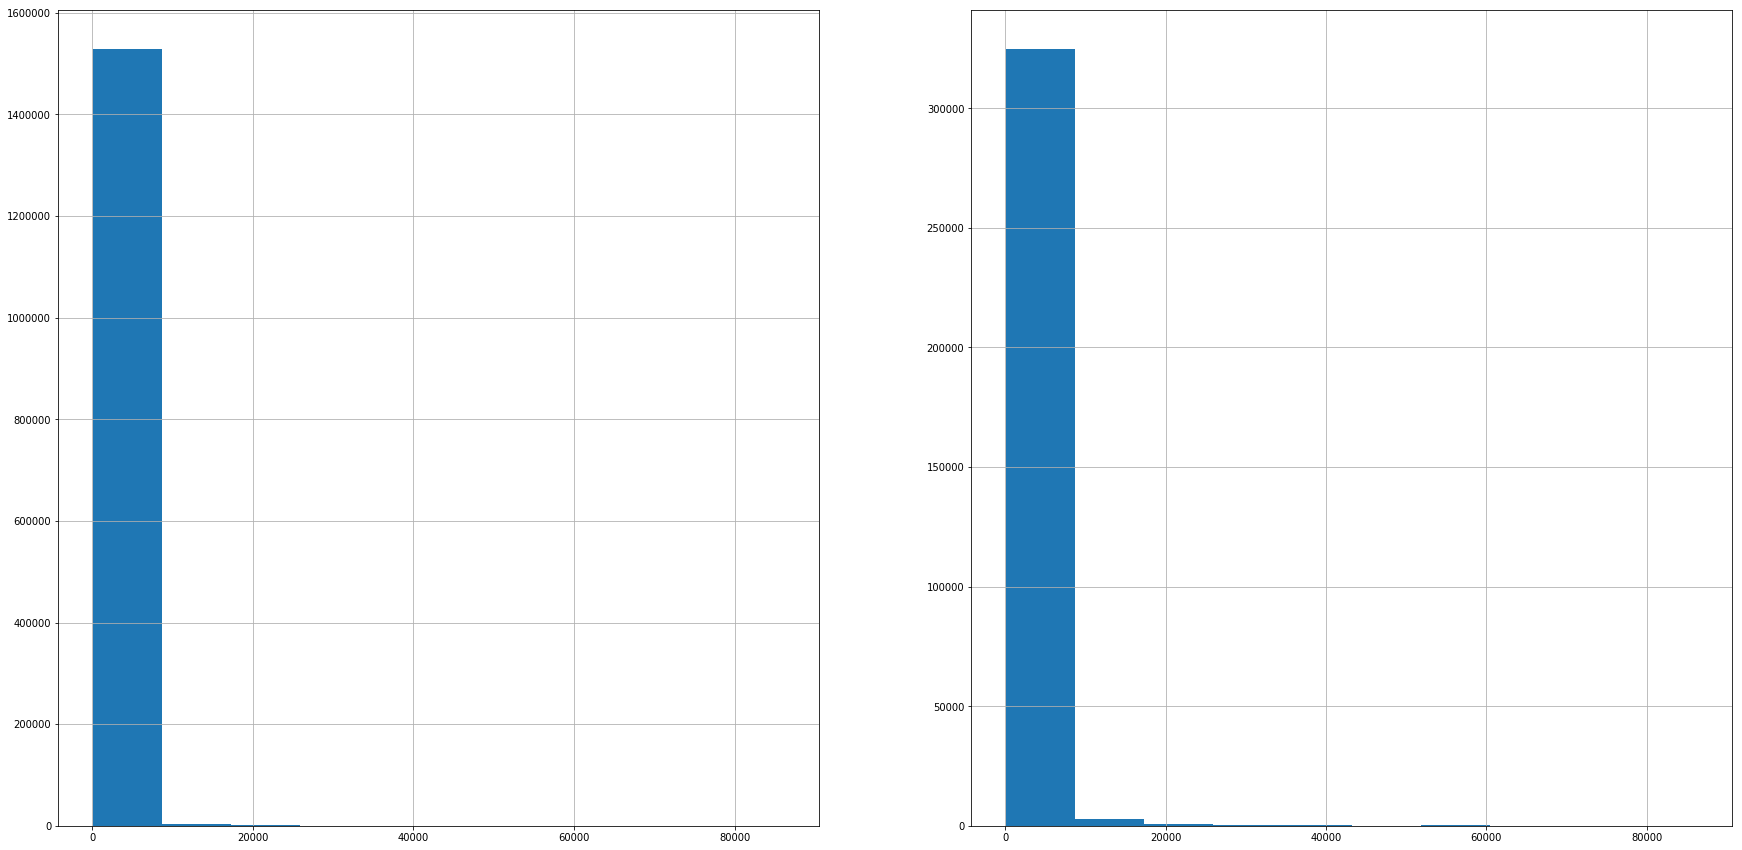

In [91]:
compare_week_to_weekend(data_frame_2018_sorted)

In [14]:
def make_trip_count_matrix(data_frame):
    # (build n_station X n_days matrix and run PCA on daily trips/start station)
    # (build 1 X n_days matrix and run PCA on daily trips/start station)
    return

In [15]:
def run_PCA(matrix):
    return

## Business and usage trends over time

In [16]:
median_duration_seconds = np.median(data_frame_2019['duration_sec'])
print(median_duration_seconds)

559.0


In [17]:
data_frame_2019

,Unnamed: 16,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,rental_access_method,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type
0,NaN,4861,No,80825,196.0,37.808894,-122.256460,Grand Ave at Perkins St,2019-02-01 16:24:49.8640,1989.0,Male,NaN,229.0,37.775745,-122.213037,Foothill Blvd at 42nd Ave,2019-01-31 17:57:44,Subscriber
1,NaN,5506,No,65900,134.0,37.752428,-122.420628,Valencia St at 24th St,2019-02-01 15:16:54.1730,1989.0,Male,NaN,4.0,37.785881,-122.408915,Cyril Magnin St at Ellis St,2019-01-31 20:58:33,Subscriber
2,NaN,2717,No,62633,157.0,37.846784,-122.291376,65th St at Hollis St,2019-02-01 11:30:46.5300,1965.0,Female,NaN,245.0,37.870139,-122.268422,Downtown Berkeley BART,2019-01-31 18:06:52,Customer
3,NaN,4557,No,44680,53.0,37.775946,-122.437777,Grove St at Divisadero,2019-02-01 08:10:50.3180,1974.0,Male,NaN,85.0,37.770083,-122.429156,Church St at Duboce Ave,2019-01-31 19:46:09,Customer
4,NaN,2100,No,60709,28.0,37.787168,-122.388098,The Embarcadero at Bryant St,2019-02-01 07:10:51.0650,NaN,NaN,NaN,16.0,37.794130,-122.394430,Steuart St at Market St,2019-01-31 14:19:01,Customer
5,NaN,3532,No,6733,266.0,37.862464,-122.264791,Parker St at Fulton St,2019-02-01 00:28:04.5120,1994.0,Male,NaN,245.0,37.870139,-122.268422,Downtown Berkeley BART,2019-01-31 22:35:50,Subscriber
6,NaN,5114,No,1188,146.0,37.742314,-122.423180,30th St at San Jose Ave,2019-02-01 00:14:27.9000,1984.0,Male,NaN,34.0,37.783988,-122.412408,Father Alfred E Boeddeker Park,2019-01-31 23:54:38,Subscriber
7,NaN,3967,No,1254,314.0,37.333988,-121.894902,Santa Clara St at Almaden Blvd,2019-02-01 00:09:44.4970,1991.0,Male,NaN,318.0,37.330698,-121.888979,San Carlos St at Market St,2019-01-31 23:48:50,Subscriber
8,NaN,4813,No,3153,70.0,37.773311,-122.444293,Central Ave at Fell St,2019-02-01 00:09:39.4570,1979.0,Male,NaN,29.0,37.782405,-122.439446,O'Farrell St at Divisadero St,2019-01-31 23:17:05,Subscriber
9,NaN,1976,No,323,129.0,37.758862,-122.412544,Harrison St at 20th St,2019-02-01 00:05:11.1770,1991.0,Male,NaN,223.0,37.764765,-122.420091,16th St Mission BART Station 2,2019-01-31 23:59:47,Subscriber


In [18]:
data_frame_2017['start_time'][:]


0        2017-12-31 16:57:39
1        2017-12-31 15:56:34
2        2017-12-31 22:45:48
3        2017-12-31 17:31:10
4        2017-12-31 14:23:14
5        2017-12-31 22:51:00
6        2017-12-31 23:49:28
7        2017-12-31 23:46:37
8        2017-12-31 23:37:07
9        2017-12-31 23:35:38
10       2017-12-31 23:46:32
11       2017-12-31 23:48:11
12       2017-12-31 23:52:55
13       2017-12-31 23:52:55
14       2017-12-31 23:35:23
15       2017-12-31 23:53:38
16       2017-12-31 23:54:40
17       2017-12-31 23:55:09
18       2017-12-31 23:52:49
19       2017-12-31 23:46:33
20       2017-12-31 23:59:01
21       2017-12-31 22:52:22
22       2017-12-31 23:54:25
23       2017-12-31 23:35:55
24       2017-12-31 23:36:03
25       2017-12-31 23:36:16
26       2017-12-31 23:36:34
27       2017-12-31 23:38:24
28       2017-12-31 23:37:47
29       2017-12-31 23:39:13
                 ...        
519670   2017-06-28 10:45:45
519671   2017-06-28 10:44:17
519672   2017-06-28 10:13:23
519673   2017-

In [19]:
# Total Number of trips per month for the 3 years
# Can do error bars by bootstrapping 


In [20]:
# Median duration of trips per month for the 3 years
# Can do error bars by bootstrapping 

hc, bin_edges = np.histogram(duration_seconds, range = (0, 5000) )
print(hc)
a = np.hstack(duration_seconds)
_ = plt.hist(duration_seconds, bins = bin_edges)  

NameError: name 'duration_seconds' is not defined

In [ ]:
# Trip start time distribution: weekdays vs weekends

In [ ]:
# Trip duration distribution: weekdays vs weekends

In [ ]:
# All to all flow chart of trips between stations: year by year

In [ ]:
# Analyze dimensionality of the data (build n_station X n_days matrix and run PCA on daily trips/start station) 

## User profile

In [ ]:
# Median age of trips per month for the 3 years
# Can do error bars by bootstrapping 

In [ ]:
# Male and female percentage of trips per month for the 3 years
# Can do error bars by bootstrapping 

In [ ]:
# Age distribution by gender - Wilcoxon Rank sum test

In [ ]:
# Pairwise analysis of start time, trip duration and age - do users cluster over certain dimensions

In [ ]:
# Calculate distance from latitude and longitude - check correlation between age and distance

## Forecasting

In [ ]:
#How well can you predict #trips a day based on historical data?


In [ ]:
#Does more data help or hurt predictions?


In [ ]:
#Is weather data predictive or postdictive of #trips?


In [ ]:
#Can NN beat simple forecasting analyses (different flavors from basic next day prediction to Linear Regression)? Play with window size 